# Sentiment Analysis Using the Sentiment140 Dataset

In this notebook, we aim to accomplish the following:
1. Import and analyze the Sentiment140 dataset.
2. Prepare the data for model training
3. Implement a train-validation split to evaluate our model's performance.
4. Train a tokenizer on the training data and tokenize the data
5. Pad the data on a selected length
6. Construct and train a neural network model that includes an embedding layer for text representation.
7. Inspect the output dimensionality of the embedding layer.
8. Train the model to classify the sentiment of tweets and evaluate its performance using the validation set.
9. Tune the hyper parameters for the tokenization and model training.

## Introduction
For this exercise, we'll be using a subsample of the Sentiment140 dataset from Kaggle.
Sentiment140 is a popular dataset for sentiment analysis that contains 1.6 million tweets labeled for sentiment. This dataset is widely used for training machine learning models to differentiate between positive and negative sentiment in text.

You can download the dataset [here](https://github.com/opencampus-sh/course-material/blob/main/machine-learning-with-tensorflow/week-05/sentiment140_small.csv).

Please download the dataset and upload it to your Google Drive.
By uploading the data to your Google Drive and not directly to your Colab environment, it is persistently available. You just need to run the cell the code to mount your Google Drive to your Colab environment.

The dataset contains the following 6 fields:  
`target`: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)  
`ids`: The id of the tweet ( 2087)  
`date`: the date of the tweet (Sat May 16 23:58:44 UTC 2009)  
`flag`: The query (lyx). If there is no query, then this value is NO_QUERY.  
`user`: the user that tweeted (robotickilldozr)  
`text`: the text of the tweet (Lyx is cool)  

## Google Drive Setup
Before proceeding, ensure that you have uploaded the Sentiment140 dataset to your Google Drive in a specified folder. Then, use the following code to mount your Google Drive and access files using the path '/content/drive/MyDrive/'.

In [4]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


## Importing Data
Next, we will import the dataset and examine it using descriptive statistics to gain initial insights.

In [9]:
import pandas as pd

# Define column names
column_names = ["target", "ids", "date", "flag", "user", "text"]

# Update this to the path of your Sentiment140 dataset file
file_path = '/content/drive/MyDrive/sentiment140_small.csv'
data = pd.read_csv(file_path, encoding='ISO-8859-1', names=column_names)  # Note: The encoding may vary based on your dataset specifics

data.head()  # View the first few rows of the dataset


,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,2200003313,Tue Jun 16 18:18:13 PDT 2009,NO_QUERY,DEWGetMeTho77,@Nkluvr4eva My poor little dumpling In Holmde...
2,0,2262462245,Sat Jun 20 22:33:33 PDT 2009,NO_QUERY,amikanai,not again tila i love tequila
3,0,2181612958,Mon Jun 15 12:03:52 PDT 2009,NO_QUERY,klayerbear,@Rach_x13 im just ill .. got a banging hedache
4,0,1795702941,Thu May 14 08:13:36 PDT 2009,NO_QUERY,MaRaNdA_x0,Might not get to see her boyfriend for a month...


### Descriptive Statistics

In [14]:
# Average number of words in each tweet
avg_words = data['text'].apply(lambda x: len(x.split(' '))).mean()
print(f"Average number of words per tweet: {avg_words}")

Average number of words per tweet: 14.385710089311942


In [15]:
# Summary statistics for numerical columns
print(data.describe())

              target           ids
count  160001.000000  1.600010e+05
mean        2.004687  1.999298e+09
std         2.000001  1.935712e+08
min         0.000000  1.467810e+09
25%         0.000000  1.957035e+09
50%         4.000000  2.002246e+09
75%         4.000000  2.177264e+09
max         4.000000  2.329205e+09


In [16]:
# Class distribution
class_distribution = data['target'].value_counts()  # Replace 'your_label_column' with the actual column name for labels
print(f"Class distribution:\n{class_distribution}")

Class distribution:
target
4    80188
0    79813
Name: count, dtype: int64


## Prepare Labels

In [17]:
# Labels must start at 0 and increase sequentially by 1 to mark the different classes
# Converting target labels from {0, 2, 4} to {0, 1, 2}
label_mapping = {0: 0, 2: 1, 4: 2}
data['label'] = data['target'].map(label_mapping) # INCLUDE YOUR CODE HERE

data['label'].value_counts()

# Another option would be to use one-hot encoding to represent the labels, where each class is represented by a vector of 0s and a 1 in the position of the class label

label
2    80188
0    79813
Name: count, dtype: int64

## Removing Stop Words

Stop words are common words that generally do not contribute much meaning in a sentence and are typically removed in the preprocessing stage of traditional text analysis. This helps in reducing the size of the dataset and improves the performance of the model by focusing on words that carry more meaning.

In this section, we will use the NLTK library, a widely-used Python library for natural language processing, to remove stop words from our dataset.


In [18]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

def remove_stop_words(data):
    stop_words = set(stopwords.words('english'))
    return [" ".join([word for word in sentence.split() if word.lower() not in stop_words]) for sentence in data]

# Add new column including the texts without stopwords
data['text_without_stopwords'] = remove_stop_words(data['text'])

# print the first few rows of the text columns
data[['text', 'text_without_stopwords']].head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,text,text_without_stopwords
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...","@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,@Nkluvr4eva My poor little dumpling In Holmde...,@Nkluvr4eva poor little dumpling Holmdel vids ...
2,not again tila i love tequila,tila love tequila
3,@Rach_x13 im just ill .. got a banging hedache,@Rach_x13 im ill .. got banging hedache
4,Might not get to see her boyfriend for a month...,Might get see boyfriend month mom wont let com...


In [19]:
# Average number of words in each tweet without stopwords
avg_words_without_stopwords = data['text_without_stopwords'].apply(lambda x: len(x.split(' '))).mean()
print(f"Average number of words per tweet without stopwords: {avg_words_without_stopwords}")

Average number of words per tweet without stopwords: 8.118430509809313


## Splitting Data into Training and Test Sets

Before training our model, it is essential to split the dataset into training and test sets. This approach helps in assessing the performance of the model on unseen data, ensuring that our evaluations are realistic and our model is not overfitting to the training data.

We will use a typical split ratio of 80% for training and 20% for testing. You can adjust this ratio based on your dataset size and requirements.


In [20]:
from sklearn.model_selection import train_test_split

# Assuming 'data' is your dataframe and 'labels' is the column with sentiment labels
X_train, X_test, y_train, y_test = train_test_split(
    data['text_without_stopwords'], data['label'], test_size=0.2, random_state=42) # replace 'your_text' and 'your_labels' with the actual column names for text and labels

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")


Training set size: 128000
Test set size: 32001


## Tokenization Function
The following function will be responsible for tokenizing our text data. We'll use Keras' Tokenizer class, which allows us to vectorize a text corpus by turning each text into a sequence of integers. The `oov_token` parameter is used to handle out-of-vocabulary words during text conversion.


In [21]:
# Install TensorFlow library for text processing (if not already installed - for Colab you can skip it)
%pip install tensorflow_text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 39.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 83.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 70.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 80.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 54.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 25.1 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      S

In [22]:
# Import libraries
from tensorflow.keras.preprocessing.text import Tokenizer # Implement tokenizer function

# Define the tokenizer
tokenizer = Tokenizer(oov_token="<OOV>", num_words = 0) # Change the num_words parameter to the desired number of words that your dictionary should contain

# Train the tokenizer
tokenizer.fit_on_texts(X_train)
# INCLUDE YOUR CODE HERE

# Tokenize the data
X_train_sequences = tokenizer.texts_to_sequences(X_train)# INCLUDE YOUR CODE HERE
X_test_sequences = tokenizer.texts_to_sequences(X_test)

# Create a datframe with the original and the tokenized data to check the tokenization for the first rows
pd.DataFrame(zip(X_train, X_train_sequences), columns=['text', 'sequence']).head()

,text,sequence
0,"Resort lines suck 2010, Minus Marc Jacobs? I'm...","[8101, 2197, 542, 3163, 2564, 7144, 13548, 2, ..."
1,@TheRealJordin happy 4 u!!! sit couch relax u ...,"[3629, 60, 90, 20, 1058, 1476, 1370, 20, 25, 4..."
2,@camiknickers URGH! Bet keep skipping back one...,"[21247, 2164, 685, 187, 6317, 17, 18, 1273, 12..."
3,missed 2 full days twittering b/c can't get ap...,"[173, 33, 401, 95, 1409, 237, 427, 26, 5, 910,..."
4,bored! wish went ice skating rink miss mi fren...,"[183, 59, 146, 520, 5013, 10471, 40, 2102, 338..."


## Padding
To ensure consistent input shape for modeling, we apply padding to our tokenized text. Padding adjusts the sequence length so that all inputs are of the same length, which is necessary for batch processing in neural networks.

In this step, it important to decide on the best maximum length of sequences for padding. This length affects both the model's performance and computational efficiency. If the maximum length is too long, it may lead to increased computational costs and may include lots of padding for shorter sequences. On the other hand, if it's too short, valuable information might be lost.

In this section, we will analyze the distribution of sequence lengths in our dataset and choose an appropriate maximum length. This is often a balance between capturing enough information and maintaining computational efficiency.



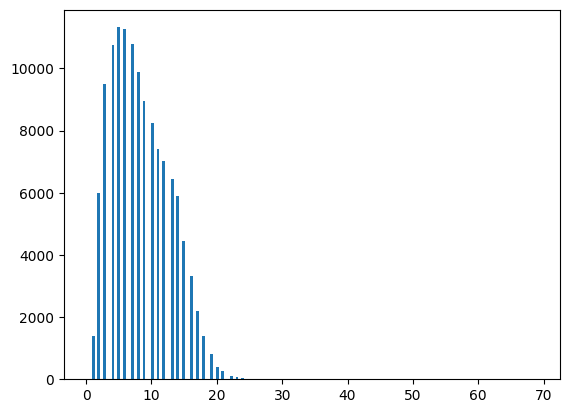

Longest sequence:  69


In [23]:
# Plot distribution of sequence lengths
import matplotlib.pyplot as plt

plt.hist([len(sequence) for sequence in X_train_sequences], bins=160)
plt.show()

# print maximum sequence length
print("Longest sequence: ", max([len(sequence) for sequence in X_train_sequences]))

In [25]:
import numpy as np
from keras.preprocessing.sequence import pad_sequences

# Determine the maximum sequence length
max_len = max(len(sequence) for sequence in X_train_sequences)
max_words = 10000
# Pad the sequences
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_len)
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_len)
X_train_padded[X_train_padded >= max_words] = 0
X_test_padded[X_test_padded >= max_words] = 0

print(f"Padded training sequences shape: {X_train_padded.shape}")
print(f"Padded test sequences shape: {X_test_padded.shape}")

Padded training sequences shape: (128000, 69)
Padded test sequences shape: (32001, 69)


## Model Construction
Now, we will define our neural network model, incorporating an embedding layer to capture text representation effectively.


In [26]:
from keras.models import Sequential
from keras.layers import Embedding, Dense, GlobalAveragePooling1D

# Define model parameters

vocab_size = 10000  # Replace with your vocabulary size as defined in the tokenization step
max_length = 69  # Replace with your maximum sequence length as defined in the padding step
embedding_dim = 128  # Size of the embedding vectors
num_classes = 3


# Define the model architecture
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
model.add(GlobalAveragePooling1D()),
model.add(Dense(20, activation='relu')),
model.add(Dense(units=num_classes, activation='softmax'))


model.build(input_shape=(None, max_len))

# Display the model's architecture
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 69, 128)             │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 20)                  │           2,580 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │              63 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,282,643 (4.89 MB)

 Trainable params: 1,282,643 (4.89 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
# Inspect the embedding layer dimensions after training the model
embedding_layer_weights = model.layers[0].get_weights()[0]
print(f"Shape of embedding layer weights: {embedding_layer_weights.shape}")


Shape of embedding layer weights: (10000, 128)


## Model Fitting

In this section, we will compile and train our model.

In [28]:
# Compile and train the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy']) # The loss function can either be `sparse_categorical_crossentropy` or `categorical_crossentropy`, depending on how you ave encoded your labels
history = model.fit(X_train_padded, y_train, epochs=30, batch_size=1024, validation_data=(X_test_padded, y_test)) # Replace your_train_texts, your_train_labels, your_test_texts, your_test_labels with the actual variables containing your data



Epoch 1/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.5210 - loss: 0.7192 - val_accuracy: 0.6702 - val_loss: 0.6783
Epoch 2/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 19s 116ms/step - accuracy: 0.6231 - loss: 0.6731 - val_accuracy: 0.6887 - val_loss: 0.6446
Epoch 3/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 21s 117ms/step - accuracy: 0.6885 - loss: 0.6310 - val_accuracy: 0.6610 - val_loss: 0.6030
Epoch 4/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 21s 119ms/step - accuracy: 0.7092 - loss: 0.5816 - val_accuracy: 0.7270 - val_loss: 0.5550
Epoch 5/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 23s 182ms/step - accuracy: 0.7440 - loss: 0.5393 - val_accuracy: 0.7550 - val_loss: 0.5279
Epoch 6/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 17s 137ms/step - accuracy: 0.7508 - loss: 0.5199 - val_accuracy: 0.7532 - val_loss: 0.5199
Epoch 7/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 19s 124ms/step - accuracy: 0.7585 - loss: 0.5077 - val_accuracy: 0.7378 - val_loss: 0.5252
Epoch 8/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 22s 136ms/step - accuracy: 0.7628 - loss: 0

Use the code of above to compile and train your data again but replace definition of `validation_data` with `validation_split=0.2` argument (see below).  
Why is this approach of defining the validation data not recommended?

In [29]:
# Compile and train the model
# INCLUDE YOUR CODE HERE
history_val_split = model.fit(X_train_padded, y_train, epochs=30, batch_size=1024, validation_split=0.2)# INCLUDE YOUR CODE HERE

Epoch 1/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 0.7996 - loss: 0.4394 - val_accuracy: 0.8002 - val_loss: 0.4411
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 110ms/step - accuracy: 0.8007 - loss: 0.4380 - val_accuracy: 0.7911 - val_loss: 0.4502
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - accuracy: 0.8009 - loss: 0.4355 - val_accuracy: 0.7923 - val_loss: 0.4487
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 128ms/step - accuracy: 0.8028 - loss: 0.4321 - val_accuracy: 0.7962 - val_loss: 0.4463
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 128ms/step - accuracy: 0.8021 - loss: 0.4329 - val_accuracy: 0.7950 - val_loss: 0.4460
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 120ms/step - accuracy: 0.8033 - loss: 0.4316 - val_accuracy: 0.7922 - val_loss: 0.4476
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 114ms/step - accuracy: 0.8074 - loss: 0.4242 - val_accuracy: 0.7931 - val_loss: 0.4485
Epoch 8/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 22s 128ms/step - accuracy: 0.8066 - loss: 0

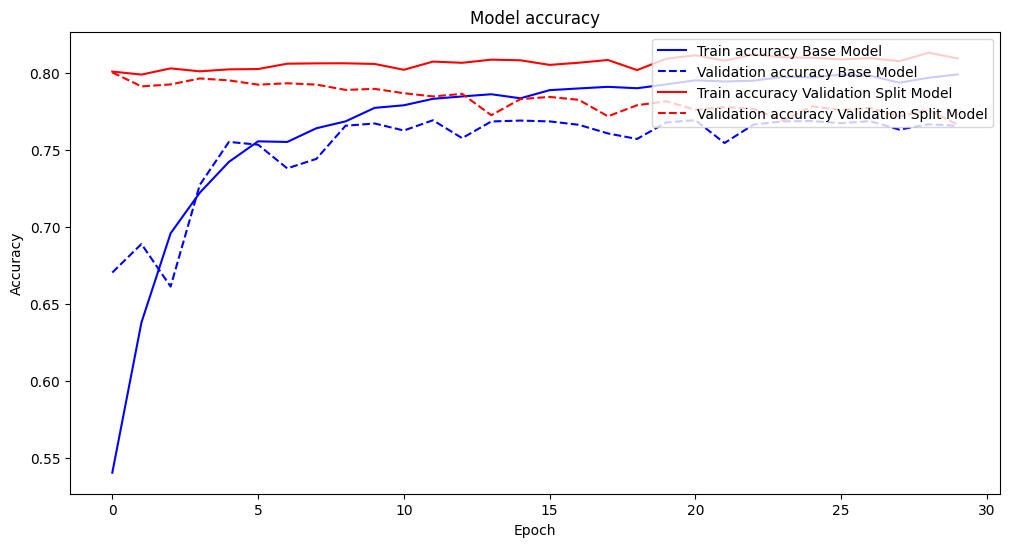

In [30]:
# Plot training & validation accuracy values for both models of above
plt.figure(figsize=(12, 6))

# Plot accuracy for the first model
plt.plot(history.history['accuracy'], 'b-', label='Train accuracy Base Model')
plt.plot(history.history['val_accuracy'], 'b--', label='Validation accuracy Base Model')

# Plot accuracy for the second model
plt.plot(history_val_split.history['accuracy'], 'r-', label='Train accuracy Validation Split Model')
plt.plot(history_val_split.history['val_accuracy'], 'r--', label='Validation accuracy Validation Split Model')

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

## Hyperparameter Tuning

Now that you have a basic understanding of how to construct and train a text classification model using Keras, you can experiment with the model to improve its performance. One way to do this is by tuning the model's hyperparameters.

Here are a few hyperparameters you can experiment with:

1. **Vocabulary Size**: This is the number of unique words in your text data. A larger vocabulary size means the model can recognize more unique words, but it also increases the dimensionality of the data and can lead to overfitting. Try reducing the vocabulary size to see if it improves the model's performance.

2. **Maximum Sequence Length**: This is the length of the input sequences. If you increase the maximum sequence length, the model will be able to process longer sequences, but it will also take longer to train and may be more prone to overfitting. Try decreasing the maximum sequence length to see if it improves the model's performance.

3. **Embedding Dimensionality**: This is the size of the vectors in which words will be embedded. A higher dimensionality can capture more nuanced relationships between words, but it also increases the computational cost and can lead to overfitting. Try experimenting with different embedding dimensionalities to see what works best.

Remember, the goal of hyperparameter tuning is to find the combination of hyperparameters that gives the best performance on your validation data. Happy tuning!

In [31]:
# Define variables
max_len = X_train_padded.shape[1]  # Assuming X_train_padded is already defined
num_classes = 3  # Assuming there are 3 classes in your dataset

# Define a function to build and train the model with different hyperparameters
def build_and_train_model(vocab_size, max_len, embedding_dim, epochs, batch_size):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len))
    model.add(GlobalAveragePooling1D())
    model.add(Dense(20, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Ensure all indices are within the vocabulary range
    X_train_padded[X_train_padded >= vocab_size] = 0
    X_test_padded[X_test_padded >= vocab_size] = 0

    history = model.fit(X_train_padded, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test_padded, y_test))
    return history

# Experiment with different hyperparameters
histories = []
for vocab_size in [5000, 10000, 20000]:
    for embedding_dim in [64, 128, 256]:
        history = build_and_train_model(vocab_size, max_len, embedding_dim, epochs=10, batch_size=1024)
        histories.append((vocab_size, embedding_dim, history))



Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.4981 - loss: 0.7371 - val_accuracy: 0.6798 - val_loss: 0.6803
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.6639 - loss: 0.6751 - val_accuracy: 0.5754 - val_loss: 0.6588
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.6835 - loss: 0.6437 - val_accuracy: 0.7097 - val_loss: 0.6077
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.7165 - loss: 0.5957 - val_accuracy: 0.7385 - val_loss: 0.5628
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.7374 - loss: 0.5544 - val_accuracy: 0.7465 - val_loss: 0.5385
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.7470 - loss: 0.5308 - val_accuracy: 0.7524 - val_loss: 0.5260
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.7522 - loss: 0.5192 - val_accuracy: 0.7560 - val_loss: 0.5177
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.7631 - loss: 0.5060 - val_accu